In [2]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical


## Data Loading and Processing

In [3]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'

In [4]:
# data loading
data = scipy.io.loadmat(DATA_DIR+'x.mat')  
columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(data['x'].shape[1]) for j in range(data['x'].shape[2])])
data['x'].shape
labels = pd.read_csv(DATA_DIR+"table_withlabels.csv")
foof = pd.read_csv(DATA_DIR+"foof2features.csv")
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
df.columns = columns
df['IDs'] = foof['C1']
df = pd.merge(df, labels[['label', 'IDs']], on='IDs', how='inner')
print(df['label'].value_counts())

Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


In [5]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [6]:
# data splitting

train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'])

train_labels, test_labels = train_df['label'], test_df['label']
test_labels_categorical = to_categorical(test_df['label']-1)

train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]

## AutoEncoder for Feature Extraction

In [7]:
n_inputs = train_features.shape[1]

visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)

d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

output = Dense(n_inputs, activation='linear')(d)

model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
encoder = Model(inputs=visible, outputs=bottleneck)

plot_model(encoder, 'encoder_compress.png', show_shapes=True)
encoder.save('autoencoder.h5')

Epoch 1/50
79/79 - 6s - loss: 5.3306 - 6s/epoch - 79ms/step
Epoch 2/50
79/79 - 5s - loss: 3.2746 - 5s/epoch - 61ms/step
Epoch 3/50
79/79 - 5s - loss: 3.1880 - 5s/epoch - 62ms/step
Epoch 4/50
79/79 - 5s - loss: 3.7920 - 5s/epoch - 62ms/step
Epoch 5/50
79/79 - 5s - loss: 4.0035 - 5s/epoch - 61ms/step
Epoch 6/50
79/79 - 5s - loss: 3.2664 - 5s/epoch - 61ms/step
Epoch 7/50
79/79 - 5s - loss: 3.1876 - 5s/epoch - 61ms/step
Epoch 8/50
79/79 - 5s - loss: 3.2904 - 5s/epoch - 61ms/step
Epoch 9/50
79/79 - 5s - loss: 2.9967 - 5s/epoch - 62ms/step
Epoch 10/50
79/79 - 5s - loss: 3.0887 - 5s/epoch - 61ms/step
Epoch 11/50
79/79 - 5s - loss: 3.2886 - 5s/epoch - 61ms/step
Epoch 12/50
79/79 - 5s - loss: 2.7964 - 5s/epoch - 61ms/step
Epoch 13/50
79/79 - 5s - loss: 2.6676 - 5s/epoch - 61ms/step
Epoch 14/50
79/79 - 5s - loss: 2.7424 - 5s/epoch - 61ms/step
Epoch 15/50
79/79 - 5s - loss: 2.5350 - 5s/epoch - 61ms/step
Epoch 16/50
79/79 - 5s - loss: 2.8484 - 5s/epoch - 62ms/step
Epoch 17/50
79/79 - 5s - loss: 2.

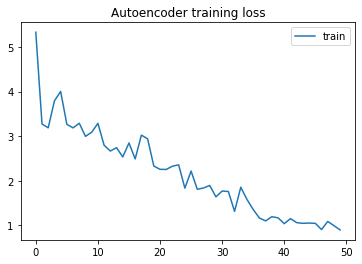

In [8]:
  # plot loss
  plt.plot(history.history['loss'], label='train')
  plt.title('Autoencoder training loss')
  plt.legend()
  plt.show()

In [9]:
# encode the data
encoder= load_model('autoencoder.h5', compile=False)

train_features_encoded = encoder.predict(train_features)
test_features_encoded = encoder.predict(test_features)

## Dealing with imbalance

In [10]:
oversample = SMOTE()
train_features_encoded_oversampled, train_labels_oversampled = oversample.fit_resample(train_features_encoded, train_labels)
train_features_oversampled, train_labels_oversampled_ = oversample.fit_resample(train_features, train_labels)

train_labels_oversampled_categorical = to_categorical(train_labels_oversampled-1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [14]:
if 'google.colab' in str(get_ipython()):
  np.save('train_features_encoded_oversampled.npy', train_features_encoded_oversampled)
  np.save('train_labels_oversampled.npy', train_labels_oversampled)
  np.save('train_features_encoded.npy', train_features_encoded)
  np.save('test_features_encoded.npy', test_features_encoded)

In [11]:
# scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_encoded_oversampled = scaler.fit_transform(train_features_encoded_oversampled)
test_features_encoded = scaler.transform(test_features_encoded)

train_features_encoded_oversampled = np.clip(train_features_encoded_oversampled, -5, 5)
test_features_encoded = np.clip(test_features_encoded, -5, 5)

In [12]:
print(train_features_encoded_oversampled.shape)
print(train_labels_oversampled.shape)
print(train_labels_oversampled_categorical.shape)
print(test_features_encoded.shape)
print(test_labels.shape)

(2064, 4148)
(2064,)
(2064, 6)
(536, 4148)
(536,)


## Linear Models

### SVC

In [38]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features_encoded)

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True, is_categorical=False):
    
    if is_categorical:
      y_test = np.argmax(y_test, axis=1)
      y_pred = np.argmax(y_pred, axis=1)

    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='macro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()


In [ ]:
evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.22014925373134328
Precision: 0.22014925373134328
Recall: 0.22014925373134328
F1 score: 0.22014925373134328


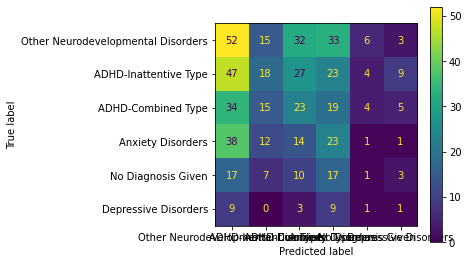

In [ ]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [ ]:
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(random_state=0, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.22014925373134328
Precision: 0.22014925373134328
Recall: 0.22014925373134328
F1 score: 0.22014925373134328


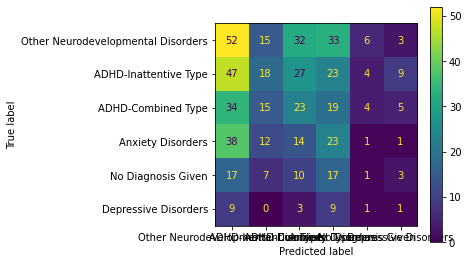

In [ ]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features_encoded)

Accuracy: 0.21082089552238806
Precision: 0.21082089552238806
Recall: 0.21082089552238806
F1 score: 0.21082089552238809


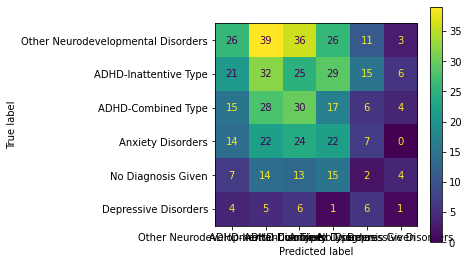

In [ ]:
evaluate(test_labels, predicted_labels_rf)

### MLP


In [198]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_mlp = clf.predict(test_features_encoded)

Iteration 1, loss = 1.91460059
Iteration 2, loss = 1.04807638
Iteration 3, loss = 1.06649717
Iteration 4, loss = 1.00358536
Iteration 5, loss = 0.96826151
Iteration 6, loss = 0.78722836
Iteration 7, loss = 0.78528317
Iteration 8, loss = 0.86598982
Iteration 9, loss = 0.78105043
Iteration 10, loss = 0.70482758
Iteration 11, loss = 0.79958908
Iteration 12, loss = 0.83555400
Iteration 13, loss = 0.80237787
Iteration 14, loss = 0.73034413
Iteration 15, loss = 0.80735463
Iteration 16, loss = 0.71168144
Iteration 17, loss = 0.77591432
Iteration 18, loss = 0.70328118
Iteration 19, loss = 0.73209586
Iteration 20, loss = 0.71396422
Iteration 21, loss = 0.73255616
Iteration 22, loss = 0.74789217
Iteration 23, loss = 0.71820902
Iteration 24, loss = 0.77071016
Iteration 25, loss = 0.70028745
Iteration 26, loss = 0.67034225
Iteration 27, loss = 0.69912280
Iteration 28, loss = 0.71582353
Iteration 29, loss = 0.69302062
Iteration 30, loss = 0.63723355
Iteration 31, loss = 0.61132152
Iteration 32, los

Accuracy: 0.20149253731343283
Precision: 0.19369819535977606
Recall: 0.17563495467741155
F1 score: 0.1747184348515011


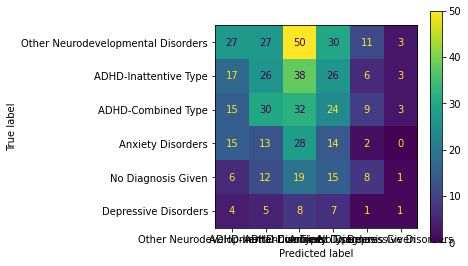

In [199]:
evaluate(test_labels, predicted_labels_mlp)

## CNNs

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D 
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
# print('Tensorflow Version: ',tensorflow.__version__)
from tensorflow.keras.layers import BatchNormalization

def get_CNN_classifier():
  # Initialising the CNN
  model = Sequential()
  # Convolution
  model.add(Conv1D(filters = 32, kernel_size = 3, input_shape = (79, 105), activation = 'relu', padding = 'same'))
  # Pooling
  model.add(MaxPooling1D(pool_size = 2))
  # Convolution
  model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (39, 32), activation = 'relu', padding = 'same'))
  model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (39, 64), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =128, kernel_size = 3, input_shape = (19, 64), activation = 'relu', padding = 'same'))
  # model.add(Conv1D(filters =128, kernel_size = 3, input_shape = (19, 128), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =256, kernel_size = 3, input_shape = (9, 128), activation = 'relu', padding = 'same'))
  #model.add(Conv1D(filters =256, kernel_size = 3, input_shape = (9, 256), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =512, kernel_size = 3, input_shape = (4, 256), activation = 'relu', padding = 'same'))
  #model.add(Conv1D(filters =512, kernel_size = 3, input_shape = (4, 512), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters = 1024, kernel_size = 3, input_shape = (2, 512), activation = 'relu', padding = 'same'))
  model.add(Conv1D(filters = 1024, kernel_size = 3, input_shape = (2, 1028), activation = 'relu', padding = 'same'))
  model.add(MaxPooling1D(pool_size = 2))
  # Flattening
  model.add(Flatten())

  model.add(Dense(units = 6, activation = 'softmax'))
  # Compiling the CNN
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  
  return model

CNN_model = get_CNN_classifier()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 79, 32)            10112     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 39, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0

In [15]:
# data reshaping for CNN
n_electrode = 105
n_freq =79 

train_features_oversampled_reshaped = train_features_oversampled.to_numpy().reshape((train_features_oversampled.shape[0], n_electrode, n_freq))
test_features_reshaped = test_features.to_numpy().reshape((test_features.shape[0], n_electrode, n_freq))

In [30]:
history_CNN = CNN_model.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.1935 - val_accuracy: 0.9540
Epoch 2/100
52/52 [==============================] - 1s 12ms/step - loss: 8.7603e-04 - accuracy: 1.0000 - val_loss: 0.1719 - val_accuracy: 0.9613
Epoch 3/100
52/52 [==============================] - 1s 12ms/step - loss: 7.1727e-04 - accuracy: 1.0000 - val_loss: 0.1271 - val_accuracy: 0.9613
Epoch 4/100
52/52 [==============================] - 1s 11ms/step - loss: 4.3967e-04 - accuracy: 1.0000 - val_loss: 0.1175 - val_accuracy: 0.9637
Epoch 5/100
52/52 [==============================] - 1s 11ms/step - loss: 2.9139e-04 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9661
Epoch 6/100
52/52 [==============================] - 1s 11ms/step - loss: 1.2584e-04 - accuracy: 1.0000 - val_loss: 0.1063 - val_accuracy: 0.9637
Epoch 7/100
52/52 [==============================] - 1s 12ms/step - loss: 2.5123e-04 - accuracy: 1.0000 - val_loss: 0.1030 - val

Accuracy: 0.20522388059701493
Precision: 0.1872247841269056
Recall: 0.17965540837788796
F1 score: 0.1817777707957006


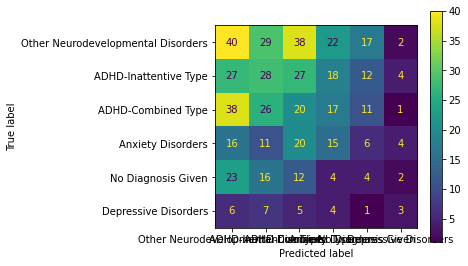

In [31]:
predicted_labels_cnn = CNN_model.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn, is_categorical=True)

In [32]:
from tensorflow.keras.layers import Conv2D , MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def get_CNN_2_classifier():

    k = 3  # kernel size
    s = 2  # stride
    n_filters = 32  # number of filters
    inputs = Input(shape=(79, 105, 1))

    conv1 = Conv2D(n_filters, kernel_size=(k, k), strides=(s, s), padding='same')(inputs)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = Conv2D(n_filters, kernel_size=(k, k), padding='same')(conv1)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)

    conv2 = Conv2D(2 * n_filters, kernel_size=(k, k), strides=(s, s), padding='same')(pool1)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = Conv2D(2 * n_filters, kernel_size=(k, k), padding='same')(conv2)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)

    conv3 = Conv2D(4 * n_filters, kernel_size=(k, k), padding='same')(pool2)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(4 * n_filters, kernel_size=(k, k), padding='same')(conv3)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)

    conv4 = Conv2D(8 * n_filters, kernel_size=(k, k), padding='same')(pool3)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(8 * n_filters, kernel_size=(k, k), padding='same')(conv4)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)

    conv5 = Conv2D(16 * n_filters, kernel_size=(k, k), padding='same')(pool4)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(16 * n_filters, kernel_size=(k, k), padding='same')(conv5)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)

    gap = GlobalAveragePooling2D()(conv5)
    outputs = Dense(6, activation='softmax')(gap)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
  
    return model

CNN_model_2 = get_CNN_2_classifier()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 79, 105, 1)]      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 40, 53, 32)        320       
                                                                 
 batch_normalization_28 (Bat  (None, 40, 53, 32)       96        
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 40, 53, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 40, 53, 32)        9248      
                                                                 
 batch_normalization_29 (Bat  (None, 40, 53, 32)       96        
 chNormalization)                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
history_CNN_2 = CNN_model_2.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)


Epoch 1/100
52/52 [==============================] - 2s 17ms/step - loss: 1.8273 - accuracy: 0.2901 - val_loss: 1.8401 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 1s 12ms/step - loss: 1.1581 - accuracy: 0.5924 - val_loss: 1.9026 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 1s 12ms/step - loss: 0.7293 - accuracy: 0.7735 - val_loss: 1.9554 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 1s 12ms/step - loss: 0.4369 - accuracy: 0.8934 - val_loss: 2.0570 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 1s 12ms/step - loss: 0.2102 - accuracy: 0.9649 - val_loss: 2.2798 - val_accuracy: 0.0000e+00
Epoch 6/100
52/52 [==============================] - 1s 12ms/step - loss: 0.1374 - accuracy: 0.9721 - val_loss: 2.3008 - val_accuracy: 0.0000e+00
Epoch 7/100
52/52 [==============================] - 1s 12ms/step - loss: 0.0990 - accuracy: 0.9812 - val_loss: 2.7166 - val

Accuracy: 0.208955223880597
Precision: 0.16921816836922854
Recall: 0.16966991321158717
F1 score: 0.16864930850141982


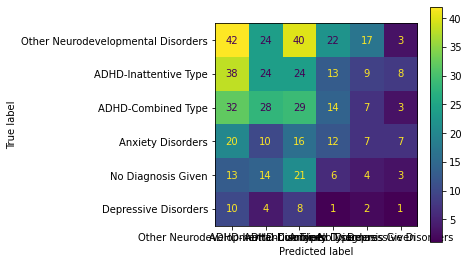

In [34]:
predicted_labels_cnn_2 = CNN_model_2.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn_2, is_categorical=True)

In [23]:
def get_CNN_3_classifier():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(79, 105, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(6, activation='softmax'))

  model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model

CNN_model_3 = get_CNN_3_classifier()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 77, 103, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 51, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 38, 51, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 36, 49, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 24, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
history_cnn_3 = CNN_model_3.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
52/52 [==============================] - 1s 12ms/step - loss: 1.7085 - accuracy: 0.2362 - val_loss: 2.2508 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6814 - accuracy: 0.2623 - val_loss: 2.2565 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6652 - accuracy: 0.2732 - val_loss: 2.2251 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6555 - accuracy: 0.3022 - val_loss: 2.3312 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6391 - accuracy: 0.2841 - val_loss: 2.2712 - val_accuracy: 0.0339
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6312 - accuracy: 0.3168 - val_loss: 2.2167 - val_accuracy: 0.0000e+00
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6031 - accuracy: 0.3240 - val_loss: 2.3439 - val_accuracy:

Accuracy: 0.22388059701492538
Precision: 0.21115954911021326
Recall: 0.20085666397204335
F1 score: 0.20368267637290846


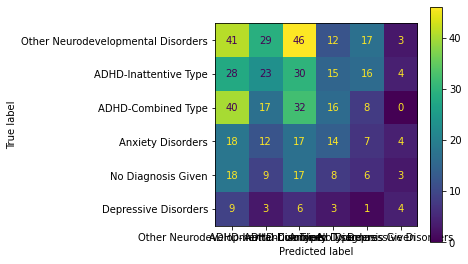

In [25]:
predicted_labels_cnn_3 = CNN_model_3.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn_3, is_categorical=True)

## Ensemble Learning

In [54]:
from self_paced_ensemble import SelfPacedEnsembleClassifier

clf = SelfPacedEnsembleClassifier(base_estimator=RandomForestClassifier(max_depth=5, random_state=0, verbose=True), n_estimators=5)


clf.fit(train_features, train_labels)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


ValueError: ignored